In [292]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
import pandas as pd
import numpy as np
## separando en train, test 
from sklearn.model_selection import train_test_split
## Configuración del RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import random

- La tabla de métricas de tu mejor modelo
- La curva ROC
- La curva de precision y recall
- Las tablas de métricas obtenidas de la clase Group de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Group
- Las tablas de métricas obtenidas de la clase Bias de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Bias (disparidad)
- Las tablas de métricas obtenidas de la clase Fairness de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Fairness (equidad)

In [24]:
import pickle

In [29]:
#feature_importance = pickle.load(
#    open('/Users/ele/Documents/EquiposGit/Intro/Intropruebapipe/IntroCD_proy1/outputs/fe_df_imp_features.pkl','rb'))

In [30]:
#feature_importance.sort_values(by="importance", ascending=False)

In [31]:
#feature_importances_

In [32]:
# ytest
y_test = pickle.load(
    open('/Users/ele/Documents/EquiposGit/Intro/Intropruebapipe/IntroCD_proy1/outputs/y_test.pkl','rb'))

In [111]:
y_test.shape

(414942,)

In [115]:
random.seed(1)

In [123]:
# predicciones con el mejor predictor 
#predicted_scores = pickle.load(
#    open('/Users/ele/Documents/EquiposGit/Intro/Intropruebapipe/IntroCD_proy1/outputs/test_predict_scores.pkl','rb'))

In [131]:
#predicted_scores

array([[0.71259143, 0.28740857],
       [0.85976458, 0.14023542],
       [0.84693228, 0.15306772],
       ...,
       [0.71259143, 0.28740857],
       [0.71259143, 0.28740857],
       [0.71259143, 0.28740857]])

In [242]:
p = np.random.beta(20000, 10000,414942)
p

array([0.6692743 , 0.66854324, 0.66581812, ..., 0.66960653, 0.66733046,
       0.66017671])

In [256]:
predicted_scores=np.vstack((p,1-p)).T
#predicted_scores.reshape(414942,2)
predicted_scores

array([[0.6692743 , 0.3307257 ],
       [0.66854324, 0.33145676],
       [0.66581812, 0.33418188],
       ...,
       [0.66960653, 0.33039347],
       [0.66733046, 0.33266954],
       [0.66017671, 0.33982329]])

In [257]:
predicted_labels = np.random.binomial(1,predicted_scores[:,1])

In [258]:
# predicciones de las etiquetas con los mejores parámetros encontrados
#predicted_labels = pickle.load(
#    open('/Users/ele/Documents/EquiposGit/Intro/Intropruebapipe/IntroCD_proy1/outputs/test_predict_labs.pkl','rb'))

In [259]:
sum(predicted_labels)

138644

In [260]:
predicted_labels.shape

(414942,)

In [261]:
predicted_scores.shape

(414942, 2)

In [262]:
#predicted_scores[:,1]

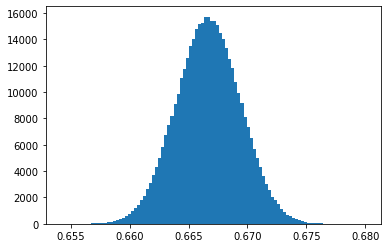

In [264]:
#plt.hist(predicted_scores[:,0],bins=100)
plt.hist(predicted_scores[:,0],bins=100)
plt.show()

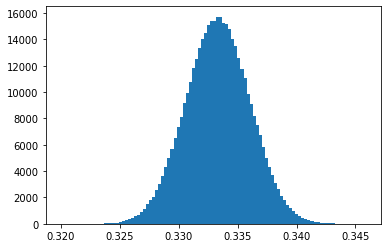

In [293]:
plt.hist(predicted_scores[:,1],bins=100)
plt.show()

## Métricas de desempeño

### ROC y AUC

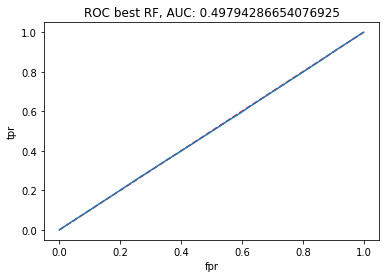

In [294]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

### Matriz de confusión

In [320]:
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
confu0=confusion_matrix(y_test, predicted_labels, normalize='all')
confu1=confusion_matrix(y_test, predicted_labels)

In [325]:
print(tabulate(np.array([['True Positive (tp)', 'False Negative (fn)'],
                    ['False Positive (fp)', 'True Negative (tn)']]),
               headers=['Dato\Predicción','Etiqueta +','Etiqueta -'],
               showindex=['Etiqueta +','Etiqueta -'],
               tablefmt='pretty'))

+-----------------+---------------------+---------------------+
| Dato\Predicción |     Etiqueta +      |     Etiqueta -      |
+-----------------+---------------------+---------------------+
|   Etiqueta +    | True Positive (tp)  | False Negative (fn) |
|   Etiqueta -    | False Positive (fp) | True Negative (tn)  |
+-----------------+---------------------+---------------------+


In [317]:
print(tabulate(confu1,
               headers=['Dato\Predicción','Etiqueta +','Etiqueta -'],
               showindex=['Etiqueta +','Etiqueta -'],
               tablefmt='pretty'))

+-----------------+------------+------------+
| Dato\Predicción | Etiqueta + | Etiqueta - |
+-----------------+------------+------------+
|   Etiqueta +    |   219886   |   110752   |
|   Etiqueta -    |   56412    |   27892    |
+-----------------+------------+------------+


In [327]:
print(tabulate(confu0,
               headers=['Dato\Predicción','Etiqueta +','Etiqueta -'],
               showindex=['Etiqueta +','Etiqueta -'],
               tablefmt='pretty'))

+-----------------+---------------------+---------------------+
| Dato\Predicción |     Etiqueta +      |     Etiqueta -      |
+-----------------+---------------------+---------------------+
|   Etiqueta +    |  0.529919844219192  | 0.26690959218396787 |
|   Etiqueta -    | 0.13595153057535753 | 0.06721903302148252 |
+-----------------+---------------------+---------------------+


#### Accuracy

$$accuracy=\frac{\text{tp+tn}}{\text{tp+fp+tn+fn}}= \frac{\text{predichos correctamente}}{\text{total}}$$

#### Precision


$$precision=\frac{\text{tp}}{\text{tp+fp}}= \frac{\text{predichos positivos correctos}}{\text{predichos positivos}}$$

De los que identificamos como clase positiva, cuántos identificamos correctamente -pureza en nuestra predicción-. 

### Recall

$$recall=\frac{\text{tp}}{\text{tp+fn}}= \frac{\text{predichos positivos correctos}}{\text{datos positivos}}$$

Del universo posible de nuestra clase positiva, cúantos identificamos correctamente

#### F1-score

Combina precision y recall para obtimizar ambos.

$$F=2\cdot  \left( \frac{\text{precision}\cdot \text{recall}}{\text{precision + recall}} \right)$$

In [329]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

In [330]:
#### Accuracy
accuracy_score(y_test, predicted_labels)

0.5971388772406746

In [332]:
#### Precision, recall, thresholds
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [334]:
thresholds_2 = np.append(thresholds_2, 1)

In [335]:
(precision.shape, recall.shape, thresholds_2.shape)

((414935,), (414935,), (414935,))

In [344]:
# F1_score junto con las otras medidas
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [343]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.322191,0.203174,1.000000,0.337731,1.000000,0.999976,0.000024,0.000000
1,0.322326,0.203173,0.999988,0.337727,0.999988,0.999976,0.000024,0.000012
2,0.322448,0.203174,0.999988,0.337729,0.999988,0.999967,0.000033,0.000012
3,0.322460,0.203172,0.999976,0.337726,0.999976,0.999967,0.000033,0.000024
4,0.322731,0.203174,0.999976,0.337729,0.999976,0.999955,0.000045,0.000024
...,...,...,...,...,...,...,...,...
134332,0.344683,0.250000,0.000036,0.000071,0.000036,0.000027,0.999973,0.999964
134333,0.344737,0.100000,0.000012,0.000024,0.000012,0.000027,0.999973,0.999988
134334,0.344888,0.142857,0.000012,0.000024,0.000012,0.000018,0.999982,0.999988
134335,0.344987,0.000000,0.000000,NaN,0.000000,0.000018,0.999982,1.000000


In [345]:
negocio = metrics_report[metrics_report.fpr <= 0.07]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
124910,0.337335,0.203484,0.070103,0.104281,0.070103,0.069968,0.930032,0.929897
124911,0.337335,0.203457,0.070092,0.104264,0.070092,0.069968,0.930032,0.929908
124912,0.337335,0.203492,0.070092,0.104268,0.070092,0.069953,0.930047,0.929908
124913,0.337335,0.203465,0.070080,0.104252,0.070080,0.069953,0.930047,0.929920
124914,0.337336,0.203479,0.070080,0.104254,0.070080,0.069947,0.930053,0.929920
...,...,...,...,...,...,...,...,...
134332,0.344683,0.250000,0.000036,0.000071,0.000036,0.000027,0.999973,0.999964
134333,0.344737,0.100000,0.000012,0.000024,0.000012,0.000027,0.999973,0.999988
134334,0.344888,0.142857,0.000012,0.000024,0.000012,0.000018,0.999982,0.999988
134335,0.344987,0.000000,0.000000,NaN,0.000000,0.000018,0.999982,1.000000


In [346]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.337335199097091

In [347]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [348]:
new_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

In [349]:
pd.Series(new_labels).sum()

29044

In [350]:
confusion_matrix(y_test, new_labels)

array([[307504,  23134],
       [ 78394,   5910]])

In [351]:
confusion_matrix(y_test, predicted_labels)

array([[219886, 110752],
       [ 56412,  27892]])

In [286]:
from sklearn.metrics import precision_score, recall_score

In [287]:
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [288]:
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [289]:
def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()
    
    for k in k_values:
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        top_k = get_top_k(y_scores, k)
        d['precision'] = precision_at_k(top_k)
        d['recall'] = recall_at_k(top_k, predictions)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)

    return pr_k

In [353]:
precision_at_k(y_,predicted_scores[:,1],0.2)

TypeError: Expected sequence or array-like, got <class 'int'>

In [352]:
recall_at_k(y_test,predicted_scores[:,1],0.2)

0.200678496868476